In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from package_global_functions import *

In [13]:
def ode_rho_m(t,rhom,pi,l1,l2,gamma):
    '''
    ODEs with the full set of parameters: pi, l1,l2 for linear and quadratic recruitment, gamma for cross-inhibition
    mind that these parameters are actually rescaled by r, and we integrate in the rescaled time tau = t*r
    '''
    rho, m = rhom
    drho_dtau = (1-rho)*(2*pi + l1*rho + l2/2 * (rho**2 + m**2)) - rho - gamma/2*(rho**2 - m**2)
    dm_dtau = m * ((1-rho)*(l1+l2*rho) - 1)
    return [drho_dtau,dm_dtau]

def rho_m_teo(pi,l1,l2,gamma):
    if l2 < 1e-8 and l1 > 0.0 and gamma > 0.0: # CI model; no l2
        rho = 1 - 1/l1
    else: # gamma = 0 or l1 = 0 will work fine with the general formula
        rho = 0.5 * (1-l1/l2 + 1/l2 * np.sqrt((l1+l2)**2 - 4*l2))
    m = np.sqrt(rho**2 - 4*pi/(l2 + gamma/(1-rho)))
    return (rho, m)


# functions to find the transition point l2c fot the hoi model
from scipy.optimize import bisect

def l2_line_pi0(l1):
    return 2 - l1 + 2*np.sqrt(1-l1), 2 - l1 - 2*np.sqrt(1-l1)

def eq_isoline_rho_plus(l2, l1, pi):
    term1 = l2*(1-l1/l2)**2 / 16
    term2 = ((l2 + l1)**2 - 4*l2)/(16*l2)
    term3 = (1-l1/l2)/8 * np.sqrt((l2 + l1)**2 - 4*l2)
    return term1 + term2 + term3 - pi

def thresh_line_m_rho_plus(l1s, pi):
    b_bisec = 10.0
    sols = []
    for l1 in l1s:
        if l1 < 1:
            a_bisec = l2_line_pi0(l1)[0]
        else:
            a_bisec = 1e-7
        try:
            sol, r = bisect(eq_isoline_rho_plus, a_bisec+1e-7, b_bisec, args=(l1, pi), full_output=True)
        except ValueError:
            sol = float('nan')
        except RuntimeError:
            sol = float('nan')
        sols.append(sol)
    return sols

In [39]:
# rhom0 = (1.0, 0.01)
rhom0 = (0.1, 0.09)

# combinations of parameters that yield very similar m* in both models
pi = 0.01
l1 = 1.5
other_interaction = 0.35
# another one:
pi = 0.2
l1 = 2.0
other_interaction = 1.78

# prova especifica:
pi, l1, other_interaction = 0.1, 1.5, 1.32

maxTime = 1e4

# HOI
l2, gamma = other_interaction, 0.0
# sol_hoi = solve_ivp(ode_rho_m, [0, maxTime], rhom0, t_eval = np.arange(0,maxTime+1,1), args=(pi, l1, l2, gamma))
sol_hoi = solve_ivp(ode_rho_m, [0, maxTime], rhom0, args=(pi, l1, l2, gamma))
rhom_teo_hoi = rho_m_teo(pi, l1, l2, gamma)
# tss_hoi = evoTimeDeriv_solve_ivp(sol_hoi, discard_initial=25.0, thresh=8e-5)
tss_hoi, evoDeriv = evoTimeDeriv_general(sol_hoi.t[sol_hoi.t > 50.0], sol_hoi.y[1][sol_hoi.t > 50.0], getFullEvo=True, thresh=5e-5)
tss_hoi_v2 = search_time_useStatDif(sol_hoi.t, sol_hoi.y[1], sol_hoi.y[1][-1], 0.95*sol_hoi.t)

# CI
l2, gamma = 0.0, other_interaction
sol_ci = solve_ivp(ode_rho_m, [0, maxTime], rhom0, args=(pi, l1, l2, gamma))
rhom_teo_ci = rho_m_teo(pi, l1, l2, gamma)
tss_ci = evoTimeDeriv_solve_ivp(sol_ci, discard_initial=25.0, thresh=1e-4)
tss_ci_v2 = search_time_useStatDif(sol_ci.t, sol_ci.y[1], sol_ci.y[1][-1], 0.95*sol_ci.t)
print('ms ', rhom_teo_hoi[1], rhom_teo_ci[1])
print('tss ', tss_hoi, tss_ci)
print('tss_v2', tss_hoi_v2, tss_ci_v2)

ms  0.024812290877105507 nan
tss  421.98999794823783 64.15012568418334
tss_v2 2125.4863108045056 86.0119590698331


/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_17475/10070152.py:16: RuntimeWarning: invalid value encountered in sqrt
  m = np.sqrt(rho**2 - 4*pi/(l2 + gamma/(1-rho)))
/Users/david/Desktop/Uni_code/TFM_code/non_lin_models/det_sols_non_lin/../../package_global_functions/time_evos.py:55: RuntimeWarning: overflow encountered in divide
  evo_rel_dif_to_stat = abs(evo - statVal)/statVal


In [42]:
sol_hoi.t[1:] - sol_hoi.t[:-1]

array([0.09086812, 0.90868122, 0.95773337, ..., 2.40200068, 2.40200068,
       0.3148893 ])

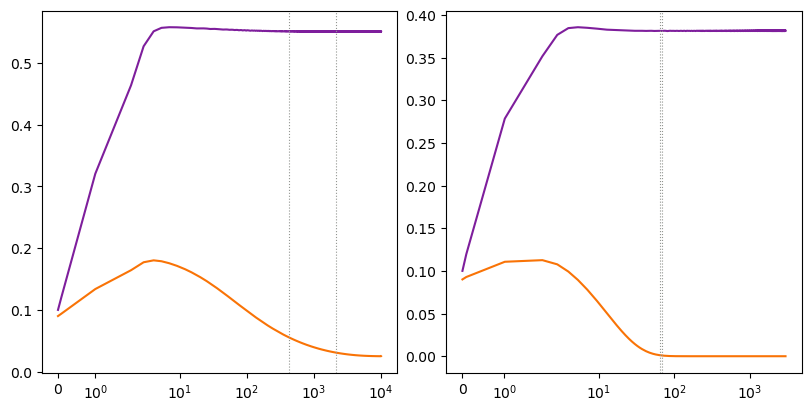

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True)
ax[0].set(xscale='symlog')
ax[1].set(xscale='symlog')

ax[0].plot(sol_hoi.t, sol_hoi.y[0], color='xkcd:purple')
ax[0].plot(sol_hoi.t, sol_hoi.y[1], color='xkcd:orange')
# ax[0].axhline(rhom_teo_hoi[1], color='xkcd:orange', ls='--', lw=0.8)
ax[0].axvline(tss_hoi, color='xkcd:gray', ls=':', lw=0.8)
ax[0].axvline(tss_hoi_v2, color='xkcd:gray', ls=':', lw=0.8)

ax[1].plot(sol_ci.t, sol_ci.y[0], color='xkcd:purple')
ax[1].plot(sol_ci.t, sol_ci.y[1], color='xkcd:orange')
# ax[1].axhline(rhom_teo_ci[1], color='xkcd:orange', ls='--', lw=0.8)
ax[1].axvline(tss_ci, color='xkcd:gray', ls=':', lw=0.8)
ax[1].axvline(tss_ci_v2, color='xkcd:gray', ls=':', lw=0.8)

In [5]:
# fig, ax = plt.subplots(1, 1)
# ax.set(yscale='symlog', xscale='symlog')
# ax.axhline(5e-5, ls=':')
# ax.plot(sol_hoi.t[sol_hoi.t > 50.0], abs(evoDeriv))

In [74]:
# some initial condition equal for all
rhom0 = (0.1, 0.01)

l1 = 1.5
# pis = [0.0, 0.01, 0.1, 0.2] # 0.2
pis = [0.01, 0.05, 0.1]
# discard_inTime = {0.0:50, 0.01:50.0, 0.1:25.0, 0.2:25.0}

intParamRange = np.arange(0.05, 5.0, 0.05) # value of l2 or gamma, depending on the model, and while the other is 0.0
intParamRange = np.concatenate([np.array([0.001,]), intParamRange])
intMaxTime_large = 1e4
intMaxTime_short = 1e3

intParamRangePi ={}

dataInt = {'hoi':{}, 'ci':{}}
for pi in pis:
    dataInt['hoi'][pi] = {'m':[], 'tss':[]}
    dataInt['ci'][pi] = {'m':[], 'tss':[]}
    # where the transition happens:
    if pi > 0.0:
        paramc = {'hoi':thresh_line_m_rho_plus([l1, ], pi)[0], 'ci':4*pi*l1/(l1-1)**2}
        # extra_intParamRange_hoi = np.arange(paramc['hoi']-1e-2, paramc['hoi']+1e-2, 1e-3)
        # extra_intParamRange_ci = np.arange(paramc['ci']-1e-2, paramc['ci']+1e-2, 1e-3)
        # intParamRange_def = np.concatenate([intParamRange, extra_intParamRange_hoi, extra_intParamRange_ci])
        # don't do so much blablabla:
    else:
        paramc = {'hoi':0.0, 'ci':0.0}
        extra_intParamRange =  np.arange(2e-3, 1e-2, 1e-3)
        intParamRange_def = np.concatenate([intParamRange, extra_intParamRange])
    intParamRange_def = np.sort(intParamRange_def)
    # store intParamRanges for x axis of figure
    intParamRangePi[pi] = intParamRange_def
    for model in ['hoi', 'ci']:
        for intParam in intParamRange_def:
            args = (pi, l1, intParam, 0.0) if model == 'hoi' else (pi, l1, 0.0, intParam)
            # add large intMaxTime if close to the transition
            if abs(intParam - paramc[model]) <= 1e-1:
                intMaxTime = intMaxTime_large
            else:
                intMaxTime = intMaxTime_short
            sol = solve_ivp(ode_rho_m, [0, intMaxTime], rhom0, t_eval = np.arange(0,intMaxTime+1,1), args=args)
            m = sol.y[1][-1] # shoud be the same as the theoretical value
            tss = search_time_useStatDif(sol.t, sol.y[1], m, 0.95*sol.t)
            dataInt[model][pi]['m'].append(m), dataInt[model][pi]['tss'].append(tss)
    # old:
    # for intParam in intParamRange:
    #     sol_hoi = solve_ivp(ode_rho_m, [0, intMaxTime], rhom0, args=(pi, l1, intParam, 0.0))
    #     sol_ci = solve_ivp(ode_rho_m, [0, intMaxTime], rhom0, args=(pi, l1, 0.0, intParam))
    #     # tss_hoi = evoTimeDeriv(sol_hoi, discard_initial=50.0)
    #     # tss_ci = evoTimeDeriv(sol_ci, discard_initial=50.0)
    #     tss_hoi = search_time_useStatDif(sol_hoi.t, sol_hoi.y[1], sol_hoi.y[1][-1], 0.95*sol_hoi.t)
    #     tss_ci = search_time_useStatDif(sol_ci.t, sol_ci.y[1], sol_ci.y[1][-1], 0.95*sol_ci.t)
    #     for k,(m,tss) in zip(['hoi', 'ci'], [(sol_hoi.y[1][-1], tss_hoi), (sol_ci.y[1][-1], tss_ci)]):
    #         dataInt[k][pi]['m'].append(m), dataInt[k][pi]['tss'].append(tss)

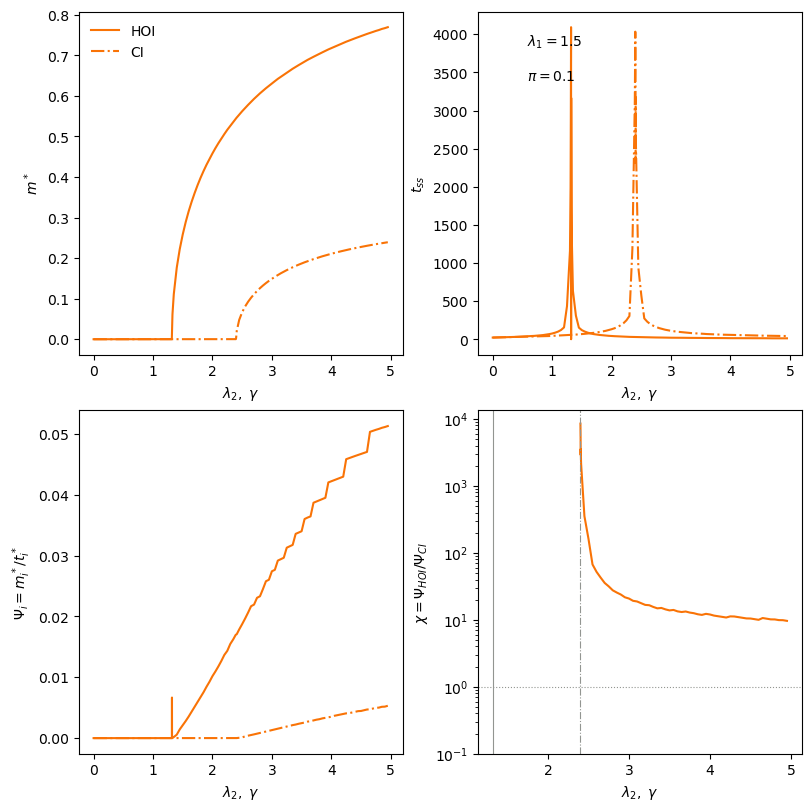

In [77]:
fig, ax = plt.subplots(2, 2, figsize=(8,8), constrained_layout=True)

ylabels = [[r'$m^*$', r'$t_{ss}$'], [r'$\Psi_i = m^*_i / t^*_i$', r'$\chi = \Psi_{HOI} / \Psi_{CI}$']]
for i in range(2):
    for j in range(2):
        ax[i,j].set(xlabel=r'$\lambda_2, \; \gamma$', ylabel=ylabels[i][j])

l1, pi = 1.5, 0.1
l2c = thresh_line_m_rho_plus([l1, ], pi)[0]
gammac = 4*pi*l1/(l1-1)**2

pis = [0.0, 0.01, 0.05, 0.1]
pi_colors = plt.cm.viridis(np.linspace(0,1,len(pis)))
c = pi_colors[pis.index(pi)]
c = 'xkcd:orange'

intParamRange = intParamRangePi[pi]
ms_hoi, ms_ci =  np.array(dataInt['hoi'][pi]['m']), np.array(dataInt['ci'][pi]['m'])
tss_hoi, tss_ci = np.array(dataInt['hoi'][pi]['tss']), np.array(dataInt['ci'][pi]['tss'])

ax[0,0].plot(intParamRange, ms_hoi, ls='-', color=c, label='HOI')
ax[0,0].plot(intParamRange, ms_ci, ls='-.', color=c, label='CI')
ax[0,0].legend(frameon=False)

ax[0,1].plot(intParamRange, tss_hoi, ls='-', color=c)
ax[0,1].plot(intParamRange, tss_ci, ls='-.', color=c)
ax[0,1].text(0.15, 0.8, rf'$\pi = {pi}$', transform=ax[0,1].transAxes)
ax[0,1].text(0.15, 0.9, rf'$\lambda_1 = {l1}$', transform=ax[0,1].transAxes)

psi_hoi, psi_ci = ms_hoi/tss_hoi, ms_ci/tss_ci
ax[1,0].plot(intParamRange, psi_hoi, ls='-', color=c)
ax[1,0].plot(intParamRange, psi_ci, ls='-.', color=c)


# plot from gammac on, as m*(ci) is diving and i want to avoid division by 0
ax[1,1].plot(intParamRange[intParamRange >= gammac], np.array(psi_hoi/psi_ci)[intParamRange >= gammac], color=c)
ax[1,1].axhline(1, ls=':', lw=0.8, color='xkcd:gray')
ax[1,1].set_yscale('log')
ax[1,1].set_ylim(1e-1, None)
ax[1,1].axvline(l2c, 0, 1, ls='-', lw=0.8, color='xkcd:gray')
ax[1,1].axvline(gammac, 0, 1, ls='-.', lw=0.8, color='xkcd:gray')

fig.savefig(f'costFuncData_hoi_vs_ci_l1_{l1}_pi_{pi}.png')